In [1]:
from azureml.core import Workspace, Experiment

# ws = Workspace.get(name="udacity-project"), only works if the name of workspace is the same

ws = Workspace.from_config()
exp = Experiment(workspace=ws, name="udacity-project")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code RHYNXDJGY to authenticate.
You have logged in. Now let us find all the subscriptions to which you have access...
Interactive authentication successfully completed.
Workspace name: quick-starts-ws-139352
Azure region: southcentralus
Subscription id: 81cefad3-d2c9-4f77-a466-99a7f541c7bb
Resource group: aml-quickstarts-139352


In [2]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# TODO: Create compute cluster
# Use vm_size = "Standard_D2_V2" in your provisioning configuration.
# max_nodes should be no greater than 4.

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/classification-credit-card-fraud/auto-ml-classification-credit-card-fraud.ipynb
# name of compute cpu cluster
cpu_cluster_name = 'compute-cluster'

#if compute instance does't exist, create a new one
try:
    compute_target = ComputeTarget(workspace = ws , name= cpu_cluster_name)
    print('There is a cluster already created with this name.')
    
except ComputeTargetException:
    print('Creating compute instance...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)
    
compute_target.wait_for_completion(show_output= True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating compute instance...
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-02-23T03:37:40.288000+00:00', 'errors': None, 'creationTime': '2021-02-23T03:37:37.588467+00:00', 'modifiedTime': '2021-02-23T03:37:52.927668+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


In [3]:
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform, choice
import os

# Specify parameter sampler
ps = RandomParameterSampling(
    {
        '--C': choice(0.001,0.1,1,10,50,100,500,1000),
        '--max_iter': choice(30,50,100,200,500)
    }
)

# Specify a Policy
# https://docs.microsoft.com/pt-br/python/api/azureml-train-core/azureml.train.hyperdrive.banditpolicy?view=azure-ml-py
policy = BanditPolicy(evaluation_interval = 2, slack_factor = 0.1)

if "training" not in os.listdir():
    os.mkdir("./training")

# Create a SKLearn estimator for use with train.py
est = SKLearn(source_directory = "./",
            compute_target=compute_target,
            vm_size='STANDARD_D2_V2',
            entry_script="train.py")



# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
# https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive.hyperdriveconfig?view=azure-ml-py
hyperdrive_config = HyperDriveConfig(hyperparameter_sampling= ps, 
                                     primary_metric_name= 'Accuracy',
                                     primary_metric_goal= PrimaryMetricGoal.MAXIMIZE,
                                     policy=policy,
                                     estimator=est,
                                     max_total_runs=20,
                                     max_duration_minutes = 30,
                                     max_concurrent_runs=4)

'SKLearn' estimator is deprecated. Please use 'ScriptRunConfig' from 'azureml.core.script_run_config' with your own defined environment or the AzureML-Tutorial curated environment.


In [4]:
# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/machine-learning-pipelines/intro-to-pipelines/aml-pipelines-parameter-tuning-with-hyperdrive.ipynb
# Submit your hyperdrive run to the experiment and show run details with the widget.
# Start the HyperDrive run
hyperdrive = exp.submit(hyperdrive_config)

# Monitor the progress of the runs with the following Jupyter widget
RunDetails(hyperdrive).show()

hyperdrive.wait_for_completion(show_output=True)

assert(hyperdrive.get_status() == "Completed")

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

RunId: HD_27448973-895f-41ae-ac5c-b5ac7cdda582
Web View: https://ml.azure.com/experiments/udacity-project/runs/HD_27448973-895f-41ae-ac5c-b5ac7cdda582?wsid=/subscriptions/81cefad3-d2c9-4f77-a466-99a7f541c7bb/resourcegroups/aml-quickstarts-139352/workspaces/quick-starts-ws-139352

Streaming azureml-logs/hyperdrive.txt

"<START>[2021-02-23T03:37:59.662455][API][INFO]Experiment created<END>\n"<START>[2021-02-23T03:38:00.6900138Z][SCHEDULER][INFO]The execution environment is being prepared. Please be patient as it can take a few minutes.<END>"<START>[2021-02-23T03:38:00.515410][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2021-02-23T03:38:00.862508][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"

Execution Summary
RunId: HD_27448973-895f-41ae-ac5c-b5ac7cdda582
Web View: https://ml.azure.com/experiments/udacity-project/runs/HD_27448973-895f-41ae-ac5c-b5ac7cdda582?wsid=/subscriptions/81cef

In [5]:
import joblib
# Get your best run and save the model from that run.
# https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive.hyperdriverun?view=azure-ml-py
best_run = hyperdrive.get_best_run_by_primary_metric()

# Returns the metrics from all the runs that were launched by this HyperDriveRun.
print("Best run metrics :",best_run.get_metrics())

Best run metrics : {'Regularization Strength:': 500.0, 'Max iterations:': 500, 'Accuracy': 0.9146181082448154}


In [6]:
from azureml.data.dataset_factory import TabularDatasetFactory

# Create TabularDataset using TabularDatasetFactory
# Data is available at: 
# "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv"

ds = TabularDatasetFactory.from_delimited_files(['https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv'])

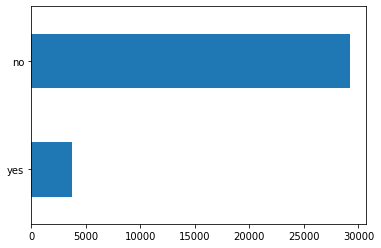

In [7]:
# verify class distribution
df_class = ds.to_pandas_dataframe()
df_class.y.value_counts().sort_values().plot(kind = 'barh')

In [8]:
from train import clean_data

# Use the clean_data function to clean your data.
x, y = clean_data(ds)

In [9]:
from azureml.train.automl import AutoMLConfig

# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.
automl_config = AutoMLConfig(compute_target = compute_target,
    experiment_timeout_minutes=30,
    task='classification',
    primary_metric='accuracy',
    training_data=ds,
    label_column_name='y',
    enable_onnx_compatible_models=True,
    n_cross_validations=2)

In [10]:
# Submit your automl run
remote_run = exp.submit(automl_config, show_output = False)
remote_run.wait_for_completion()

Running on remote.


{'runId': 'AutoML_00cb46b1-c379-41ee-a1ce-feec9e36897f',
 'target': 'compute-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-02-23T03:52:33.490598Z',
 'endTimeUtc': '2021-02-23T04:30:29.518649Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '2',
  'target': 'compute-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"udacity-project","subscription_id":"81cefad3-d2c9-4f77-a466-99a7f541c7bb","resource_group":"aml-quickstarts-139352","workspace_name":"quick-starts-ws-139352","region":"southcentralus","compute_target":"compute-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":2,"y_min":null,"y_max":null,"num_cl

In [11]:
# Retrieve and save your best automl model.
best_run, fitted_model = remote_run.get_output()
best_run.get_metrics()['accuracy']

Package:azureml-automl-runtime, training version:1.22.0, current version:1.20.0
Package:azureml-core, training version:1.22.0, current version:1.20.0
Package:azureml-dataprep, training version:2.9.1, current version:2.7.3
Package:azureml-dataprep-native, training version:29.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.7.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.22.0, current version:1.20.0
Package:azureml-defaults, training version:1.22.0, current version:1.20.0
Package:azureml-interpret, training version:1.22.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.22.0, current version:1.20.0
Package:azureml-telemetry, training version:1.22.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.22.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.22.0, current version:1.20.0


0.9159332321699545

In [12]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
udacity-project,AutoML_00cb46b1-c379-41ee-a1ce-feec9e36897f_25,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [13]:
# Delete Cluster
compute_target.delete()

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

Current provisioning state of AmlCompute is "Deleting"

